In [53]:
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.pipeline import Pipeline
import joblib

from format_data import create_dataframe
from preprocess import preprocess_supervised, OutputColumn

In [18]:
def split_target_from_dataset(Db, target='output'):  # Remove target col
    y = Db[target]
    X = Db.drop(columns=[target])
    return X, y

In [19]:
def save_model(pipeline, model_filepath):
    joblib.dump(pipeline, model_filepath)

In [20]:
data_file_path="welddb/welddb.data"
model_file_path = 'models/xgboost_model.pkl'
target = OutputColumn.yield_strength

In [ ]:
print("Loading the dataset")
Db = create_dataframe(data_file_path)
print("Preprocessing")
Db = preprocess_supervised(Db, target)

print("Split target from the dataset")
X, y = split_target_from_dataset(Db)

In [22]:
print("Train/Test split")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=21)

Train/Test split


In [40]:
print("Creating Pipelines")
pipeline_xgboost = Pipeline([('model', XGBRegressor(random_state=17))])
pipeline_catboost = Pipeline([('model', CatBoostRegressor(verbose=0, random_state=17))])
pipeline_lgbm = Pipeline([('model', LGBMRegressor(verbose=0, random_state=17))])

Creating Pipelines


In [49]:
param_grid_xgboost = {
        'model__n_estimators': [500, 600, 700, 800, 900],
        'model__max_depth': [5, 6, 7, 8, 9, 10],
        'model__eta': [0.01, 0.05, 0.1]
    }

param_grid_catboost = {
    'model__iterations': [100, 200, 300],
    'model__learning_rate': [0.01, 0.05, 0.1]
}

param_grid_lgbm = {
    'model__n_estimators': [300, 400, 500, 600],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__num_leaves': [15, 30, 50, 100]
}

In [54]:
def evaluate_pipeline(pipeline, param_grid):

    print("Performing Grid Search with Cross-Validation")
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    print("Best hyperparameters: ", grid_search.best_params_)
    print("Best cross-validation score (R2): ", grid_search.best_score_)
    # TODO: add standard deviation !

    best_model = grid_search.best_estimator_
    test_score = best_model.score(X_test, y_test)
    print("Test set score (R2) with best model: ", test_score)

    y_pred = best_model.predict(X_test)

    # Plot the predicted values against the actual values
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.7, color='blue', label='Predicted vs Actual')  # Scatter plot of predicted vs actual
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect Prediction')  # Line for perfect predictions
    
    # Set equal scaling
    plt.xlim(min(y_test), max(y_test))
    plt.ylim(min(y_test), max(y_test))
    plt.gca().set_aspect('equal', adjustable='box')  # Set equal aspect ratio

    plt.title('Predicted vs Actual values of y_test')
    plt.xlabel('Actual values')
    plt.ylabel('Predicted values')
    plt.legend()
    plt.grid()
    plt.show()

Performing Grid Search with Cross-Validation
Best hyperparameters:  {'model__eta': 0.05, 'model__max_depth': 5, 'model__n_estimators': 900}
Best cross-validation score (R2):  0.6677537628132855
Test set score (R2) with best model:  0.6904461280357814


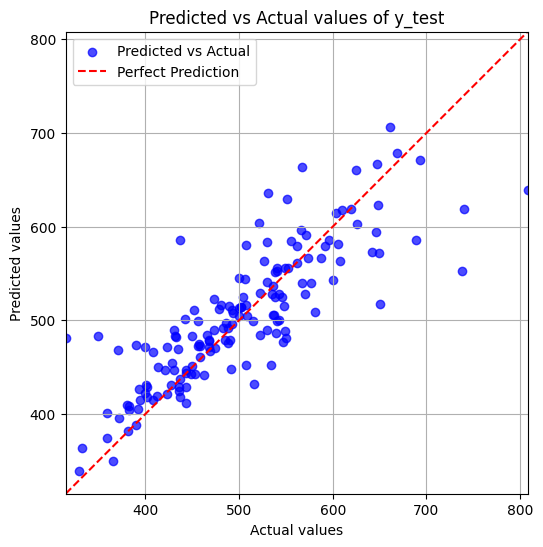

In [55]:
# XGBoost
evaluate_pipeline(pipeline_xgboost, param_grid_xgboost)

Performing Grid Search with Cross-Validation
Best hyperparameters:  {'model__iterations': 300, 'model__learning_rate': 0.1}
Best cross-validation score (R2):  0.6907094886624515
Test set score (R2) with best model:  0.685456149497903


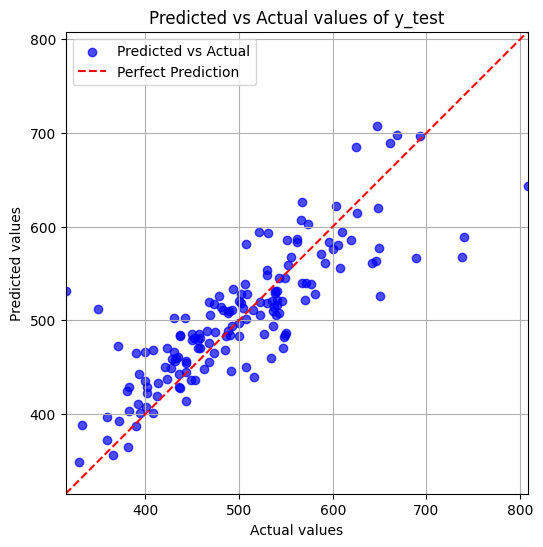

In [56]:
# CATBoost
evaluate_pipeline(pipeline_catboost, param_grid_catboost)

Performing Grid Search with Cross-Validation
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
Best hyperparameters:  {'model__learning_rate': 0.05, 'model__n_estimators': 600, 'model__num_leaves': 15}
Best cross-validation score (R2):  0.6617062308270105
Test set score (R2) with best model:  0.6984832891090085


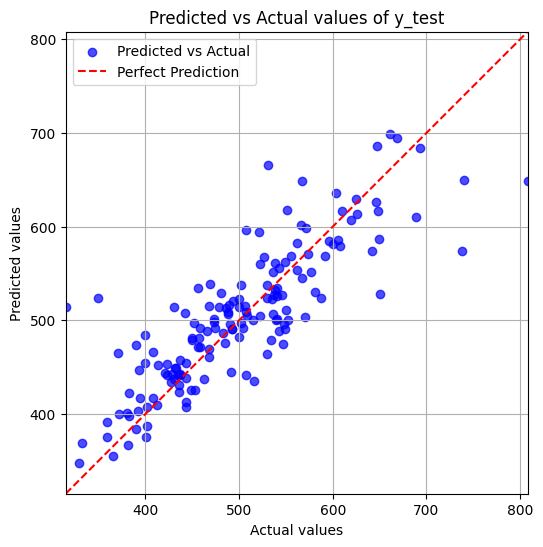

In [57]:
# LightGBM
evaluate_pipeline(pipeline_lgbm, param_grid_lgbm)

In [ ]:
print("Evaluation on test set")
# y_pred = pipeline.predict(X_test)
print("Score: ", pipeline.score(X_test, y_test))

In [ ]:
print("Saving the model")
save_model(pipeline, model_file_path)